In [2]:
from utils import *

In [3]:
boxes = [generate_box(0, 1000) for i in range(100)]
boxes[:10]

[array([[330, 330, 112, 112, 330, 330, 112, 112],
        [742, 601, 601, 742, 742, 601, 601, 742],
        [ 45,  45,  45,  45, 484, 484, 484, 484]]),
 array([[929, 929, 268, 268, 929, 929, 268, 268],
        [225, 718, 718, 225, 225, 718, 718, 225],
        [726, 726, 726, 726, 182, 182, 182, 182]]),
 array([[461, 461, 789, 789, 461, 461, 789, 789],
        [514, 503, 503, 514, 514, 503, 503, 514],
        [ 86,  86,  86,  86, 658, 658, 658, 658]]),
 array([[ 93,  93, 729, 729,  93,  93, 729, 729],
        [336, 550, 550, 336, 336, 550, 550, 336],
        [155, 155, 155, 155, 343, 343, 343, 343]]),
 array([[ 56,  56, 958, 958,  56,  56, 958, 958],
        [ 28, 651, 651,  28,  28, 651, 651,  28],
        [948, 948, 948, 948, 274, 274, 274, 274]]),
 array([[502, 502, 419, 419, 502, 502, 419, 419],
        [320, 658, 658, 320, 320, 658, 658, 320],
        [424, 424, 424, 424, 754, 754, 754, 754]]),
 array([[363, 363, 222, 222, 363, 363, 222, 222],
        [ 70, 381, 381,  70,  70, 381,

In [4]:
# Setup API
import requests
from requests.compat import urljoin
import json
from time import perf_counter

In [5]:
api_host = "http://localhost"
boxes_endpoint = "boxes/"

boxes_url = urljoin(api_host, boxes_endpoint)
response = requests.get(url=boxes_url)
response.json()[:1]

[{'x_min': 159.0,
  'x_max': 414.0,
  'y_min': 171.0,
  'y_max': 374.0,
  'z_min': 64.0,
  'z_max': 64.0,
  'id': '71a6466e-4b28-48ca-8af1-e5662d2bdb21'}]

In [6]:

for box in boxes:
    data = {
        "x_min": min(box[0]),
        "x_max": max(box[0]),
        "y_min": min(box[1]),
        "y_max": max(box[1]),
        "z_min": min(box[2]),
        "z_max": max(box[2]),
    }
    for key, value in data.items():
        data[key] = int(value)
    print(data)
    response = requests.post(urljoin(api_host, boxes_endpoint), json=data)
    assert response.status_code == 200, response.json()

{'x_min': 112, 'x_max': 330, 'y_min': 601, 'y_max': 742, 'z_min': 45, 'z_max': 484}
{'x_min': 268, 'x_max': 929, 'y_min': 225, 'y_max': 718, 'z_min': 182, 'z_max': 726}
{'x_min': 461, 'x_max': 789, 'y_min': 503, 'y_max': 514, 'z_min': 86, 'z_max': 658}
{'x_min': 93, 'x_max': 729, 'y_min': 336, 'y_max': 550, 'z_min': 155, 'z_max': 343}
{'x_min': 56, 'x_max': 958, 'y_min': 28, 'y_max': 651, 'z_min': 274, 'z_max': 948}
{'x_min': 419, 'x_max': 502, 'y_min': 320, 'y_max': 658, 'z_min': 424, 'z_max': 754}
{'x_min': 222, 'x_max': 363, 'y_min': 70, 'y_max': 381, 'z_min': 152, 'z_max': 568}
{'x_min': 712, 'x_max': 980, 'y_min': 902, 'y_max': 905, 'z_min': 320, 'z_max': 503}
{'x_min': 315, 'x_max': 964, 'y_min': 48, 'y_max': 248, 'z_min': 129, 'z_max': 511}
{'x_min': 18, 'x_max': 342, 'y_min': 498, 'y_max': 650, 'z_min': 414, 'z_max': 796}
{'x_min': 165, 'x_max': 455, 'y_min': 664, 'y_max': 906, 'z_min': 30, 'z_max': 136}
{'x_min': 125, 'x_max': 906, 'y_min': 808, 'y_max': 948, 'z_min': 502, 'z_

In [7]:
def show_3d_boxes(boxes):
    fig = go.Figure()

    for box in boxes:
        add_mesh_3d(fig, box)

    fig.update_layout(
        scene = {
            "xaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
            "yaxis": {
                "nticks": 4, 
                "range": [0, 1000],
            },
            "zaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
        },
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))

    fig.show()

In [8]:
response = requests.get(f"{boxes_url}?x=20&y=500")

In [9]:
from typing import Dict, Any

def convert_box_json_to_nparray(box_obj: Dict[str, Any]):
    del box_obj["id"]
    box_array = get_box_points_array(
        **box_obj
    )
    return box_array

convert_box_json_to_nparray(response.json()[0])

array([[  4.,   4.,  99.,  99.,   4.,   4.,  99.,  99.],
       [222., 688., 688., 222., 222., 688., 688., 222.],
       [111., 111., 111., 111., 111., 111., 111., 111.]])

In [10]:
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
response_boxes[:2]

[array([[  4.,   4.,  99.,  99.,   4.,   4.,  99.,  99.],
        [222., 688., 688., 222., 222., 688., 688., 222.],
        [111., 111., 111., 111., 111., 111., 111., 111.]]),
 array([[ 19.,  19., 324., 324.,  19.,  19., 324., 324.],
        [144., 816., 816., 144., 144., 816., 816., 144.],
        [218., 218., 218., 218., 218., 218., 218., 218.]])]

Response Time: 0.051998696002556244
Showing 239 Boxes


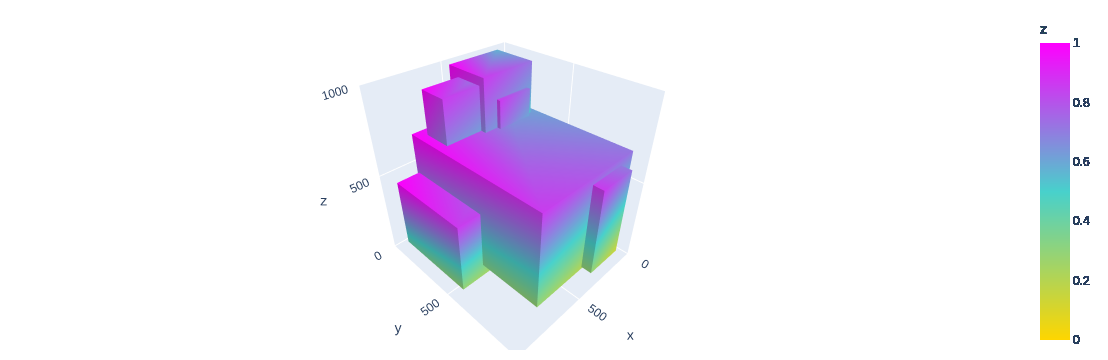

In [14]:
start = perf_counter()
response = requests.get(f"{boxes_url}?x_gte=100&x_lte=200&y=100&z=100")
end = perf_counter()
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
print(f"Response Time: {end - start}")
print(f"Showing {len(response_boxes)} Boxes")
show_3d_boxes(response_boxes[:100])

In [15]:
response = requests.get(boxes_url)
len(response.json())

1700